# Embedding a Recurrent Neural Network in an FMU

Created by [Michele Urbani](mailto:murbani@fbk.eu) on April 9th, 2025.

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split


RAW_DATA_DIR = Path("heat-propagation-data")
RAW_DATA_DIR.mkdir(parents=True, exist_ok=True)


## Simulating heat propagation in a squared plate

In [2]:
# Plate dimensions and simulation parameters
Lx, Ly = 10.0, 10.0   # Length and width of the plate
Nx, Ny = 50, 50       # Number of grid points in x and y directions
dx = Lx / Nx          # Spatial step size in x direction
dy = Ly / Ny          # Spatial step size in y direction
alpha = 0.9           # Thermal diffusivity
dt = 0.01             # Time step size
T = 25.0             # Total simulation time
T_impulse = T         # Duration of the heat impulse
T_ini = 0.0         # Initial temperature everywhere

# Staircase pulse parameters
num_steps = 5         # Number of steps in the staircase
max_temp = 200.0      # Maximum temperature during impulse
step_duration = T_impulse / num_steps  # Duration of each step

# Time-stepping parameters
Nt = int(T / dt)      # Number of time steps
Nt_impulse = int(T_impulse / dt)  # Number of steps for the impulse


In [3]:
# Function to compute the next time step using finite differences
def step(u, alpha, dx, dy, dt, n):
    for i in range(1, Nx - 1):
        for j in range(1, Ny - 1):
            u[n, i, j] = u[n - 1, i, j] + alpha * dt * (
                (u[n - 1, i + 1, j] - 2*u[n - 1, i, j] + u[n - 1, i - 1, j]) / dx**2 +
                (u[n - 1, i, j+1] - 2*u[n - 1, i, j] + u[n - 1, i, j-1]) / dy**2
            )

def run_simulation(alpha, u, T_ini, Nt, Nx, Ny, dt, dx, dy):
    """
    Parameters
    ----------
    alpha : float
        Thermal diffusivity of the plate.
    u : np.ndarray
        Temperature profile at each time step.
    T_ini : float
        Initial temperature of the plate.
    """
    # Initialize the temperature grid
    y = np.zeros((Nt, Nx, Ny))
    # Initial condition: zero everywhere
    y[0] = T_ini
    # Time-stepping loop
    for n in range(1, Nt):
        # Apply heat impulse on the left boundary (x = 0)
        y[n, :, 0] = u[n]
        # Update temperature across the plate
        step(y, alpha, dx, dy, dt, n)
    # Return only the temperature profile at the center of the plate
    return y[:, Nx//2, Ny//2]

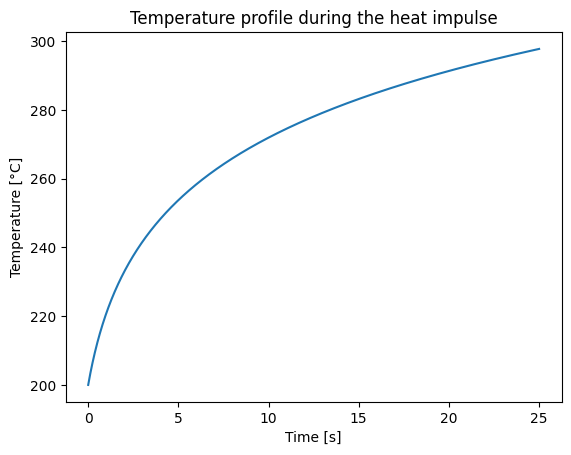

In [3]:
# Time vector
t = np.linspace(0, T, Nt)
# The initial temperature value
T_ini = 200.0
# Define a temperature profile for the heat impulse
u = 30 * np.log(t + 1) + T_ini
# Plot the temperature profile
plt.plot(t, u)
plt.xlabel('Time [s]')
plt.ylabel('Temperature [°C]')
plt.title('Temperature profile during the heat impulse')
plt.show()

In [4]:
T_plate = 0.0
# Run an example simulation
y = run_simulation(alpha, u, T_plate)
# Plot the temperature distribution at different time steps
fig, ax = plt.subplots()
ax.plot(y)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Temperature [°C]')
ax.set_title('Temperature distribution in the ceter of the plate')
ax.set_xticks(np.arange(0, 6, 1) * 500)
ax.set_xticklabels(np.arange(0, 6, 1) * 5)
plt.show()

KeyboardInterrupt: 

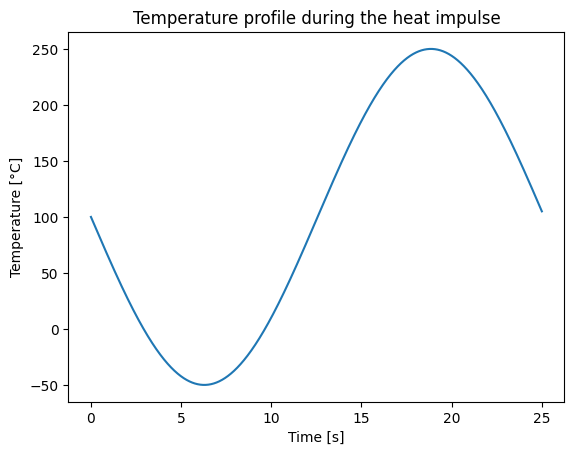

In [ ]:
# Time vector
t = np.linspace(0, T, Nt)
# The initial temperature value
T_ini = 100.0
# Define a temperature profile for the heat impulse
u = - 150 * np.sin(t / 4) + T_ini
df = pd.DataFrame(u, columns=["u"], index=t)
df.index.name = "time"
df.to_csv("input_signal.csv")
# Plot the temperature profile
plt.plot(t, u)
plt.xlabel('Time [s]')
plt.ylabel('Temperature [°C]')
plt.title('Temperature profile during the heat impulse')
plt.show()

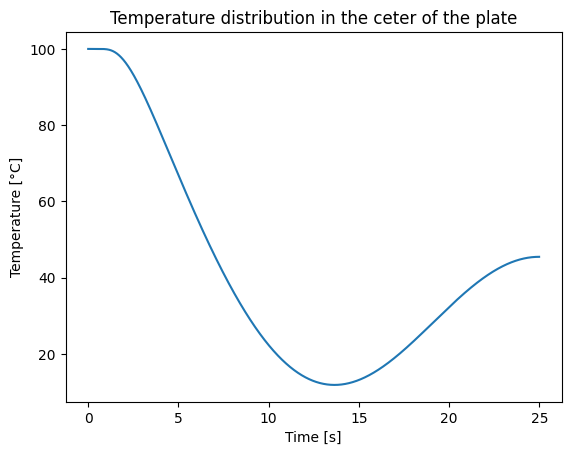

In [ ]:
T_plate = 100.0
# Run an example simulation
y = run_simulation(alpha, u, T_plate)
df = pd.DataFrame(y, columns=["y"], index=t)
df.index.name = "time"
df.to_csv("true.csv")
# Plot the temperature distribution at different time steps
fig, ax = plt.subplots()
ax.plot(y)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Temperature [°C]')
ax.set_title('Temperature distribution in the ceter of the plate')
ax.set_xticks(np.arange(0, 6, 1) * 500)
ax.set_xticklabels(np.arange(0, 6, 1) * 5)
plt.show()

## Generate data to train the model

Data are generate using only sine and cosine functions.

In [4]:
# Time duration
T = 50.0
# Time step size
dt = 0.01
Lx, Ly = 10.0, 10.0   # Length and width of the plate
Nx, Ny = 50, 50       # Number of grid points in x and y directions
dx = Lx / Nx          # Spatial step size in x direction
dy = Ly / Ny          # Spatial step size in y direction
# Number of time steps
Nt = int(T / dt)
# Time steps
t = np.linspace(0, T, Nt)
# Array to store the temperature profiles
U = []

alpha = 0.9

T_ini = 100.0
T_plate = 100.0

M = 100

# GENERATE SINUSOIDAL FUNCTIONALS
for i in range(M):
    u = (-1)**i * 20 * i * np.sin(t / 8 + i * np.pi / 8) + T_ini
    U.append({
        "alpha": alpha,
        "T_plate": T_plate,
        "u": u
    })

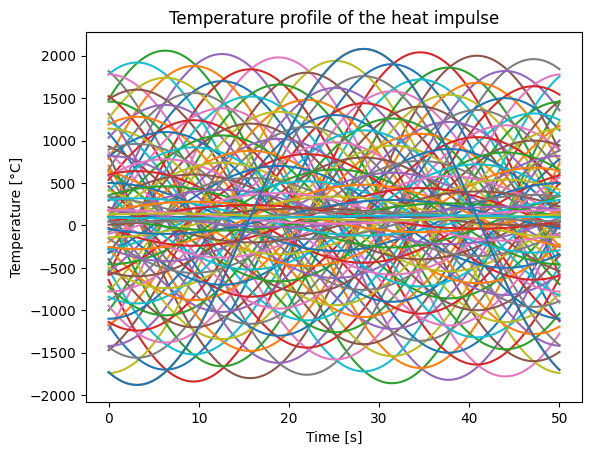

In [5]:
# Plot a temperature profile
for i in range(M):
    plt.plot(t, U[-i]["u"])
plt.plot(t, U[-1]["u"])
plt.xlabel('Time [s]')
plt.ylabel('Temperature [°C]')
plt.title('Temperature profile of the heat impulse')
plt.show()

In [6]:
# Empty list to store the temperature profiles
Y = []
# Run the simulation for each temperature profile
for u in U:
    y = run_simulation(u["alpha"], u["u"], u["T_plate"], Nt, Nx, Ny, dt, dx, dy)
    Y.append(y)

In [8]:
# Include alpha and the initial plate temperature in the datasets
# Generate dataset for the parameters alpha and T_plate
X = []
for u in U:
    X.append([u["alpha"], u["T_plate"]])
params = pd.DataFrame(X, columns=["alpha", "T_plate"])
params.to_csv(RAW_DATA_DIR / "params.csv", index=False)

In [12]:
len(y)

2500

In [7]:
# Save input/output data
for i, y in enumerate(Y):
    data = pd.DataFrame({
        "time": t,
        "u": U[i]["u"],
        "y": y,
        "alpha": U[i]["alpha"] * np.ones_like(y),
        "T_plate": U[i]["T_plate"] * np.ones_like(y)
    })
    data.to_csv(RAW_DATA_DIR / f"case_{i}.csv", index=False)

## Train the RNN


### Create PyTorch datdaset

In [2]:
# Read data
data_files = sorted(RAW_DATA_DIR.glob("case_*.csv"))
data = []
for file in data_files:
    df = pd.read_csv(file)
    data.append(df)

seq_length = 100  # Number of time steps to look back

class HeatPropagationDataset(Dataset):

    def __init__(self, data, seq_length):
        X, Y = [], []
        for series in data:
            x = series["u"].values
            y = series["y"].values
            # Create sequences of input and output data
            for i in range(len(x) - seq_length):
                X.append(x[i:i+seq_length])
                Y.append(y[i+seq_length])
        # Convert to numpy arrays
        self.x = np.array(X).astype(np.float32)
        self.y = np.array(Y).astype(np.float32)

        # Save normalization parameters
        self.x_min = np.min(x).astype(np.float32)
        self.x_max = np.max(x).astype(np.float32)
        self.y_min = np.min(y).astype(np.float32)
        self.y_max = np.max(y).astype(np.float32)

        self.x = (self.x - self.x_min) / (self.x_max - self.x_min)
        self.y = (self.y - self.y_min) / (self.y_max - self.y_min)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

### Declare the RNN model

The RNN model is designed with ONNX's *statelessness* in mind. That is, no
internal state can be stored in the ONNX model because it can't be updated at
runtime, unless the FMU code is tweaked on purpose.

In [3]:
class HeatRNN(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(HeatRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        # out = self.fc1(out)  # Predict next time step
        # out = self.relu1(out)
        out = self.fc2(out)
        return out.squeeze(1)

# Model parameters
input_size = seq_length
hidden_size = 32
output_size = 1
num_layers = 2


### Prepare for training...

In [4]:
EPOCHS = 2000
BATCH_SIZE = 64

# Split files into training and testing datasets
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_data, test_data = random_split(data, [train_size, test_size])

train_dataset = HeatPropagationDataset([train_data[-1]], seq_length)
test_dataset = HeatPropagationDataset(test_data, seq_length)

# Create DataLoader for training
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# initialize the hidden state
hidden = None

model = HeatRNN(input_size, hidden_size, output_size, num_layers)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
# Learning rate scheduler: Decays LR by gamma every step_size epochs
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


In [5]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")


Trainable parameters: 7489


In [6]:
print(f"Dataset size: {len(train_dataset)} samples")

Dataset size: 4900 samples


In [7]:
for name, param in model.named_parameters():
    print(f"Name: {name}, Shape: {param.shape}, Requires Grad: {param.requires_grad}")

Name: rnn.weight_ih_l0, Shape: torch.Size([32, 100]), Requires Grad: True
Name: rnn.weight_hh_l0, Shape: torch.Size([32, 32]), Requires Grad: True
Name: rnn.bias_ih_l0, Shape: torch.Size([32]), Requires Grad: True
Name: rnn.bias_hh_l0, Shape: torch.Size([32]), Requires Grad: True
Name: rnn.weight_ih_l1, Shape: torch.Size([32, 32]), Requires Grad: True
Name: rnn.weight_hh_l1, Shape: torch.Size([32, 32]), Requires Grad: True
Name: rnn.bias_ih_l1, Shape: torch.Size([32]), Requires Grad: True
Name: rnn.bias_hh_l1, Shape: torch.Size([32]), Requires Grad: True
Name: fc1.weight, Shape: torch.Size([32, 32]), Requires Grad: True
Name: fc1.bias, Shape: torch.Size([32]), Requires Grad: True
Name: fc2.weight, Shape: torch.Size([1, 32]), Requires Grad: True
Name: fc2.bias, Shape: torch.Size([1]), Requires Grad: True


### ... and train the RNN

In [24]:
# Set model train
model.train()
loss_tracker = []
for epoch in tqdm(range(EPOCHS), ncols=80):
    running_loss = 0.0
    for x, y in train_dataloader:
        # Outputs from the rnn
        print(x, y)
        break
    break
#         prediction = model(x)
#         # Calculate the loss
#         loss = loss_fn(prediction, y)
#         # Zero gradients
#         optimizer.zero_grad()
#         # Backward pass
#         loss.backward()
#         # Update weights
#         optimizer.step()
#         # Track loss
#         running_loss += loss.item()
#     # Log loss
#     loss_tracker.append(running_loss / len(train_dataloader))
#     # Update learning scheduler
#     # scheduler.step()

# # Save the model
# torch.save(model.state_dict(), "example3.pt")


  0%|                                                  | 0/2000 [00:00<?, ?it/s]

tensor([[0.4390, 0.4396, 0.4402,  ..., 0.4995, 0.5001, 0.5007],
        [0.0201, 0.0199, 0.0197,  ..., 0.0066, 0.0065, 0.0064],
        [0.9262, 0.9265, 0.9268,  ..., 0.9547, 0.9549, 0.9552],
        ...,
        [0.3422, 0.3428, 0.3434,  ..., 0.4007, 0.4013, 0.4020],
        [0.9882, 0.9881, 0.9880,  ..., 0.9716, 0.9714, 0.9712],
        [0.9969, 0.9968, 0.9967,  ..., 0.9864, 0.9863, 0.9861]]) tensor([1.0695e-01, 2.4022e-01, 6.1528e-01, 1.2318e-01, 1.6567e-05, 9.9254e-01,
        9.9694e-01, 4.6339e-01, 7.0329e-01, 3.5696e-01, 7.9938e-02, 9.9237e-01,
        1.6170e-02, 6.2556e-01, 6.3104e-01, 1.6347e-03, 3.2738e-02, 9.3869e-01,
        4.7059e-01, 7.5352e-01, 7.4759e-01, 4.1312e-01, 9.9898e-01, 9.5843e-01,
        5.1661e-01, 2.2588e-01, 4.7500e-02, 2.0745e-01, 3.2341e-01, 5.0535e-01,
        5.3465e-02, 9.7622e-01, 7.0376e-01, 7.1996e-06, 9.9644e-01, 6.5754e-04,
        9.6552e-02, 5.8108e-01, 8.2117e-01, 4.0333e-01, 2.3972e-01, 1.6029e-01,
        4.0455e-01, 7.8932e-02, 9.8323e-01

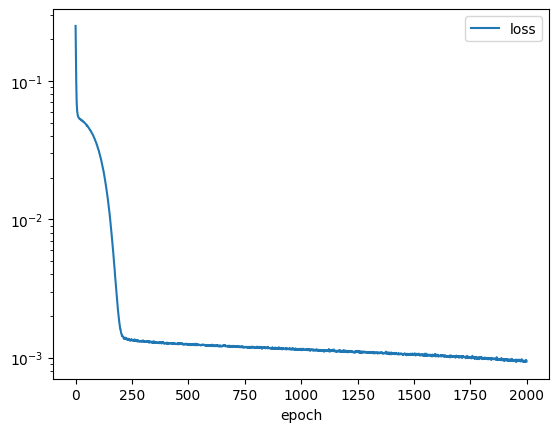

In [10]:
df_loss = pd.DataFrame({"loss": np.array([l for l in loss_tracker])})
df_loss.index.name = "epoch"
df_loss.plot(logy=True)
df_loss.to_csv("loss.csv", index=True)

### Predictions

In [25]:
train_dataset.x_min

np.float32(-839.9998)

In [23]:
model.load_state_dict(torch.load("example3.pt"))
# Use the model to predict
model.eval()
# Select a test dataset for prediction
# data = test_data.dataset[1]
data = train_data.dataset[-1]

predictions = []
# Normalize the input data
X = data['u'].values

for i in range(len(X) - seq_length):
    # Cast to tensor
    x = torch.tensor(X[i:i + seq_length], dtype=torch.float32)
    # Normalize data
    x = (x - train_dataset.x_min) / (train_dataset.x_max - train_dataset.x_min)
    # Add batch dimension
    x = x.unsqueeze(0)
    # Outputs from the rnn
    with torch.no_grad():
        y = model(x)
    # Unnormalize prediction
    y = y * (train_dataset.x_max - train_dataset.x_min) + train_dataset.x_min
    print(y, data['y'].values[i])
#     # Remove batch dimension
#     prediction = y.squeeze(0)
#     # Append predictions to the list
#     predictions.append(prediction.detach().numpy())

# # Concatenate all predictions
# predictions = np.array(predictions)

# # Plot the predictions
# plt.figure(figsize=(10, 5))
# plt.plot(np.arange(seq_length, len(X)), predictions, label="Predicted target")
# plt.plot(data['u'], label="True source")
# plt.plot(data['y'], label="True target")
# plt.xlabel("Time [ms]")
# plt.ylabel("Temperature [°C]")
# plt.title("Temperature Prediction")
# plt.grid()
# plt.legend()
# plt.show()

tensor([-835.9606]) 100.0
tensor([-838.3209]) 100.0
tensor([-840.6790]) 100.0
tensor([-843.0343]) 100.0
tensor([-845.3879]) 100.0
tensor([-847.7383]) 100.0
tensor([-850.0870]) 100.0
tensor([-852.4328]) 100.0
tensor([-854.7763]) 100.0
tensor([-857.1174]) 100.0
tensor([-859.4559]) 100.0
tensor([-861.7921]) 100.0
tensor([-864.1258]) 100.0
tensor([-866.4576]) 100.0
tensor([-868.7861]) 100.0
tensor([-871.1126]) 100.0
tensor([-873.4366]) 100.0
tensor([-875.7582]) 100.0
tensor([-878.0774]) 100.0
tensor([-880.3942]) 100.0
tensor([-882.7081]) 100.0
tensor([-885.0199]) 100.0
tensor([-887.3290]) 100.0
tensor([-889.6359]) 100.0
tensor([-891.9404]) 100.0
tensor([-894.2426]) 99.99999999999994
tensor([-896.5418]) 99.99999999999908
tensor([-898.8390]) 99.99999999999216
tensor([-901.1334]) 99.9999999999544
tensor([-903.4257]) 99.9999999997938
tensor([-905.7149]) 99.99999999922666
tensor([-908.0024]) 99.99999999749376
tensor([-910.2868]) 99.99999999278238
tensor([-912.5694]) 99.99999998115167
tensor([-9

The RNN model works fine for demonstration purposes and we decide not to refine the model further.

## Export the model to ONNX

In [18]:
# Export the model to the ONNX format
dummy_input = torch.randn(1, seq_length)

onnx_model_path = "example3.onnx"

torch.onnx.export(
    model,
    dummy_input,
    onnx_model_path,
    export_params=True,
    verbose=True,
    input_names=['input'],
    output_names=['output']
)


Exported graph: graph(%input : Float(1, 100, strides=[100, 1], requires_grad=0, device=cpu),
      %fc2.weight : Float(100, 32, strides=[32, 1], requires_grad=1, device=cpu),
      %fc2.bias : Float(100, strides=[1], requires_grad=1, device=cpu),
      %onnx::Sub_88 : Float(requires_grad=0, device=cpu),
      %onnx::Div_91 : Float(requires_grad=0, device=cpu),
      %onnx::RNN_93 : Float(1, 32, 100, strides=[3200, 100, 1], requires_grad=0, device=cpu),
      %onnx::RNN_94 : Float(1, 32, 32, strides=[1024, 32, 1], requires_grad=0, device=cpu),
      %onnx::RNN_95 : Float(1, 64, strides=[64, 1], requires_grad=0, device=cpu),
      %onnx::RNN_99 : Float(1, 32, 32, strides=[1024, 32, 1], requires_grad=0, device=cpu),
      %onnx::RNN_100 : Float(1, 32, 32, strides=[1024, 32, 1], requires_grad=0, device=cpu),
      %onnx::RNN_101 : Float(1, 64, strides=[64, 1], requires_grad=0, device=cpu),
      %onnx::Mul_106 : Float(requires_grad=0, device=cpu),
      %onnx::Add_107 : Float(requires_grad

/home/michele/onnx2fmu/.venv-notebooks/lib/python3.10/site-packages/torch/onnx/symbolic_opset9.py:4244: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with RNN_TANH can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


## Generate the FMU

In [19]:
from onnx2fmu.app import build

build(
    model_path=onnx_model_path,
    model_description_path="example3Description.json",
    target_folder="temp"
)

2025-07-15 11:47:00.001 | INFO     | onnx2fmu.app:compile:258 - Call cmake -S temp -B temp/build -D MODEL_NAME=example3 -D FMI_VERSION=2


-- The C compiler identification is GNU 13.3.0
-- The CXX compiler identification is GNU 13.3.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info


2025-07-15 11:47:01.162 | INFO     | onnx2fmu.app:compile:260 - CMake build cmake --build temp/build --config Release


-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- ONNX Runtime archive already exists at /tmp/onnxruntime/onnxruntime-linux-x64-1.20.1.tgz
-- ONNX Runtime extraction successful.
-- Configuring done (1.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/michele/onnx2fmu/tests/example3/temp/build
[ 20%] Building C object CMakeFiles/example3.dir/example3/model.c.o
[ 40%] Building C object CMakeFiles/example3.dir/src/fmi2Functions.c.o
[ 60%] Building C object CMakeFiles/example3.dir/src/cosimulation.c.o
[ 80%] Building C object CMakeFiles/example3.dir/src/ortUtils.c.o
[100%] Linking C shared library temp/example3/binaries/linux64/example3.so
modelDescription.xml
binaries
binaries/linux64
binaries/linux64/libonnxruntime.so.1.20.1
binaries/linux64/libonnxruntime.so.1
binaries/linux64/example3.so
binaries/linux64/libonnxruntime_providers_shared.s

In [20]:
u = data['u'].values
# Save input to test the FMU
df = pd.DataFrame(
    [u[i:seq_length + i] for i in range(len(u) - seq_length)],
    columns=[f"input_0_{i}" for i in range(seq_length)]
)
df['time'] = np.arange(0, len(data['u'].values) / 2 - seq_length / 2, 0.5)
df.reset_index(inplace=True, drop=True)
df.set_index("time", inplace=True)
df.to_csv("input.csv", index=True)

for c in df.columns:
    df[c].to_csv(f"{c}.csv", index=True)

## Test the FMU using FMPy

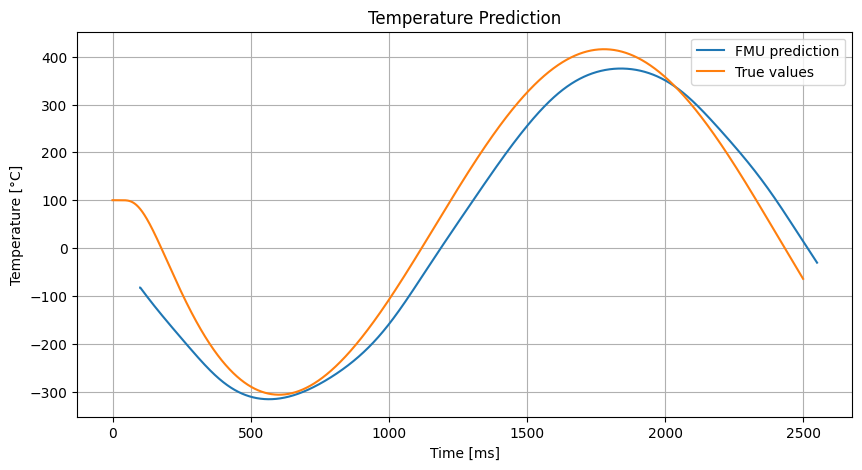

In [22]:
from fmpy import simulate_fmu, plot_result

input = np.genfromtxt("input.csv", delimiter=",", names=True)

results = simulate_fmu(
    "example3.fmu",
    start_time=0,
    stop_time=2500,
    input=input,
    output=["output_0_0"],
    validate=True,
    output_interval=0.5
)

plt.figure(figsize=(10, 5))
plt.plot(results["time"][:-seq_length] + 100, results["output_0_0"][:-seq_length], label="FMU prediction")
plt.plot(np.arange(0, 2500, 0.5), data['y'].values, label="True values")
plt.xlabel("Time [ms]")
plt.ylabel("Temperature [°C]")
plt.title("Temperature Prediction")
plt.grid()
plt.legend()
plt.show()

input_signal = pd.DataFrame({'time': np.arange(0, 25, 0.005), 'u': u}).to_csv('input_signal.csv', index=False)
true = pd.DataFrame({'time': np.arange(0, 25, 0.005), 'y': data['y'].values}).to_csv('true.csv', index=False)
predicted = pd.DataFrame(
    {'time': (results["time"][:-seq_length] + 100) / 100,
     'y': results["output_0_0"][:-seq_length]}
    ).to_csv('predicted.csv', index=False)